In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
# Models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
import nltk
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn import preprocessing

# Stats
import scipy.stats

# static:
%matplotlib inline 

In [2]:
# Read csv
data = pd.read_csv('realdata.csv')

# Define features and target
language = ['gunning_fog', 'pos', 'neg', 'neu', 'wc', 'sc', 'wps', 'dic', 'sixltr', 'insight', 'cause', 'discrep',
       'tentat', 'certain', 'quant', 'numbers', 'jargon']
metadata = [ 'Citations', 'Times Cited', 'Number Authors', 'Journal Impact Factor']
features = language + metadata
target = ['Retracted']

In [3]:
# Filter data for retracted and nonretracted data
r_df = data[data['Retracted'] == True]
r_df = r_df.drop(['Retracted'], axis=1)
r_df = r_df[features]

n_df = data[data['Retracted'] == False]
n_df = n_df.drop(['Retracted'], axis=1)
n_df = n_df[features]

In [22]:
# H0: Sample distributions are equal
lst = []
for col in features:
    lst.append((col, scipy.stats.mannwhitneyu(r_df[col], n_df[col])))

print('num retracted =', r_df.shape[0])
print('num not retracted =', n_df.shape[0])
count = 0
for elt in sorted(lst, key=lambda t: t[1].pvalue):
    if elt[1].pvalue < 0.05:
        count += 1
    print(elt)
print(count)
print(len(lst))

num retracted = 1113
num not retracted = 1064
('tentat', MannwhitneyuResult(statistic=523159.0, pvalue=1.2788636518920162e-06))
('dic', MannwhitneyuResult(statistic=534080.5, pvalue=3.770717660854322e-05))
('jargon', MannwhitneyuResult(statistic=534080.5, pvalue=3.770717660854322e-05))
('Citations', MannwhitneyuResult(statistic=550315.0, pvalue=0.0014658053591027683))
('quant', MannwhitneyuResult(statistic=549616.5, pvalue=0.001872817419119408))
('gunning_fog', MannwhitneyuResult(statistic=551929.5, pvalue=0.003062035685784797))
('numbers', MannwhitneyuResult(statistic=558166.0, pvalue=0.010287949467092659))
('discrep', MannwhitneyuResult(statistic=561466.0, pvalue=0.018280289053912508))
('insight', MannwhitneyuResult(statistic=563385.5, pvalue=0.02501824137157632))
('cause', MannwhitneyuResult(statistic=568643.5, pvalue=0.05468757747056619))
('Number Authors', MannwhitneyuResult(statistic=570253.5, pvalue=0.06674696311324145))
('Times Cited', MannwhitneyuResult(statistic=571087.0, pva

In [23]:
alpha = 0.10
best_features = [elt[0] for elt in sorted(lst, key=lambda t: t[1].pvalue) if elt[1].pvalue > alpha]

In [24]:
best_features

['certain', 'wc', 'neg', 'sc', 'sixltr', 'wps', 'neu', 'Journal Impact Factor']

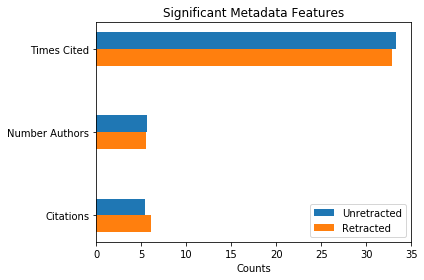

In [19]:
# Examine Best Metadata Features
new_data = data.copy()
liwc = ['insight', 'cause', 'discrep','tentat', 'certain', 'quant', 'numbers', 'jargon', 'dic', 'pos']
best_features_no_liwc = list(set(best_features) & set(metadata))
new_data[liwc] *= 100
graph_df = new_data.groupby('Retracted', as_index=True)[best_features_no_liwc].mean().transpose()

width = 0.2
plt.figure(figsize=(20,20))
fig, ax = plt.subplots()
ax.barh(graph_df.index, graph_df[graph_df.columns[0]], width, label='Unretracted', align='edge')
ax.barh(graph_df.index, graph_df[graph_df.columns[1]], -width, label='Retracted', align='edge')
plt.title('Significant Metadata Features')
plt.legend(loc='best')
plt.xlabel('Counts')

plt.tight_layout()
plt.savefig('barchart_metadata.png', dpi=400)

plt.show()

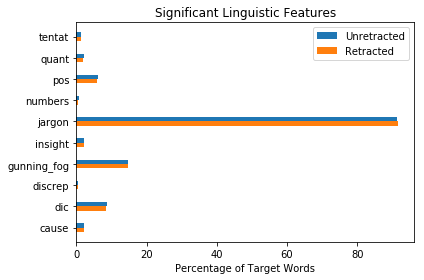

In [18]:
# Examine Best Features w/LIWC
new_data = data.copy()
liwc = ['insight', 'cause', 'discrep','tentat', 'certain', 'quant', 'numbers', 'jargon', 'dic', 'pos']

best_features_liwc = list(set(best_features) & set(language))
# Examine Best Features
new_data = data.copy()
liwc = ['insight', 'cause', 'discrep','tentat', 'certain', 'quant', 'numbers', 'jargon', 'dic', 'pos']
new_data[liwc] *= 100
graph_df = new_data.groupby('Retracted', as_index=True)[best_features_liwc].mean().transpose()

width = 0.2
plt.figure(figsize=(10,10))
fig, ax = plt.subplots()
ax.barh(graph_df.index, graph_df[graph_df.columns[0]], width, label='Unretracted', align='edge')
ax.barh(graph_df.index, graph_df[graph_df.columns[1]], -width, label='Retracted', align='edge')
plt.title('Significant Linguistic Features')
plt.legend(loc='best')
plt.xlabel('Percentage of Target Words')
plt.tight_layout()
plt.savefig('barchart_linguistic.png', dpi=400)
plt.show()

/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.55188246097337 -- Ada Boost


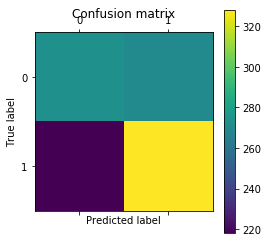

In [9]:
clf = AdaBoostClassifier()
name = 'Ada Boost'
X = data[features]
y = data[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=41, test_size=0.50)

clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)    
print("{} -- {}".format(score, name))
y_pred = clf.predict(X_test)
con_matrix = confusion_matrix(Y_test, y_pred)
plt.matshow(con_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [10]:
h = .02  # step size in the mesh
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "Linear SVC", "SGD"]
classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
#     GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LinearSVC(),
    SGDClassifier(max_iter=1000,shuffle=True)]

X = data[features]
X = preprocessing.scale(X)
y = data[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=41)

for name, clf in zip(names, classifiers):
    clf.fit(X_train, Y_train)
    score = clf.score(X_test, Y_test)    
    print("{} -- {}".format(score, name))
    # y_pred = clf.predict(X_test)
    # con_matrix = confusion_matrix(Y_test, y_pred)
    # Uncomment for confusion matrix plot
    # plt.matshow(con_matrix)
    # plt.title('Confusion matrix')
    # plt.colorbar()
    # plt.ylabel('True label')
    # plt.xlabel('Predicted label')
    # plt.show()

/Users/henrywang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5412844036697247 -- Nearest Neighbors
0.5229357798165137 -- Linear SVM
0.48073394495412847 -- RBF SVM
0.5119266055045871 -- Decision Tree
0.5229357798165137 -- Random Forest


/Users/henrywang/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:912: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5577981651376147 -- Neural Net


/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5541284403669725 -- AdaBoost
0.5339449541284403 -- Naive Bayes


/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


0.5284403669724771 -- QDA
0.5266055045871559 -- Linear SVC
0.5155963302752293 -- SGD


/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.5541284403669725 -- Ada Boost


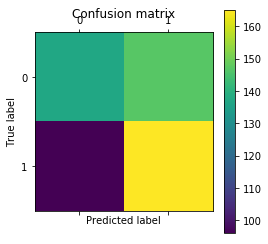

In [25]:
clf = AdaBoostClassifier()
name = 'Ada Boost'
X = data[features]
y = data[target]

X_train, X_test, Y_train, Y_test = train_test_split(X, y, random_state=41)

clf.fit(X_train, Y_train)
score = clf.score(X_test, Y_test)    
print("{} -- {}".format(score, name))
y_pred = clf.predict(X_test)
con_matrix = confusion_matrix(Y_test, y_pred)
plt.matshow(con_matrix)
plt.title('Confusion matrix')
plt.colorbar()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [30]:
X = data[features]
y = data[target]
# Using AdaBoost classifier
estimator = RandomForestClassifier()
selector = RFE(estimator, n_features_to_select=1, step=1)

selector = selector.fit(X, y)
print(selector.support_)
print(selector.ranking_)

/Users/henrywang/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[False False False False False False False False False False False False
 False False  True False False False False False False]
[11 12 13 16  9 15  4 18  2  3  5 10  8 14  1  6  7 21 17 20 19]


In [31]:
# Mask of selected features
mask = selector.support_
selected = []
for feat, mask_val in zip(features, mask):
    if mask_val:
        selected.append(feat)
selected

['quant']

In [32]:
ranks = selector.ranking_
rankings = list(zip(features, ranks))
sorted_rankings = sorted(rankings, key=lambda t: t[1])
for feat, rank in sorted_rankings:
    print('Rank:', rank, feat)

Rank: 1 quant
Rank: 2 sixltr
Rank: 3 insight
Rank: 4 wps
Rank: 5 cause
Rank: 6 numbers
Rank: 7 jargon
Rank: 8 tentat
Rank: 9 wc
Rank: 10 discrep
Rank: 11 gunning_fog
Rank: 12 pos
Rank: 13 neg
Rank: 14 certain
Rank: 15 sc
Rank: 16 neu
Rank: 17 Times Cited
Rank: 18 dic
Rank: 19 Journal Impact Factor
Rank: 20 Number Authors
Rank: 21 Citations
